# Optimization of TLN using differentiable simulation - with mismatch

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

# print(os.environ['CUDA_HOME'], os.environ['LD_LIBRARY_PATH'], os.environ['PATH'])
# Need all of these set on running the notebook
# 
# print(os.environ['CUDA_VISIBLE_DEVICES'])
# os.environ['CUDA_HOME'] = '/usr/local/cuda-12.2'
# os.environ['LD_LIBRARY_PATH'] = f'/usr/local/cuda-12.2/lib64{os.pathsep}/usr/local/cuda-12.2/extras/CUPTI/lib64'
# os.environ['PATH'] = f'/usr/local/cuda-12.2/bin{os.pathsep}{os.environ["PATH"]}'
# os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=/usr/local/cuda-12.2"
# CUDA_VISIBLE_DEVICES=7 CUDA_HOME=/usr/local/cuda-12.2 LD_LIBRARY_PATH=/usr/local/cuda-12.2/lib64:/usr/local/cuda-12.2/extras/CUPTI/lib64 PATH=/usr/local/cuda-12.2/bin:$PATH python
# print(os.environ['CUDA_VISIBLE_DEVICES'], os.environ['CUDA_HOME'])

# os.environ['CUDA_VISIBLE_DEVICES'] = '7'
import pathlib
# import setGPU  # Always use the least loaded GPU -- 1 GPU
print(os.getcwd())
while 'notebooks' in os.getcwd():
    os.chdir('..')
if 'examples' not in os.getcwd():
    os.chdir('examples')
if 'tln' not in os.getcwd():
    os.chdir('tln')
print(os.getcwd())


/lfs/ampere9/0/roed/projects/Ark
/lfs/ampere9/0/roed/projects/Ark/examples/tln


In [3]:
%config InlineBackend.figure_formats = ['svg']
# Library imports
import numpy as np
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['figure.dpi'] = 200
import matplotlib.pyplot as plt

# Enable GPU compilation cache
from jax.experimental.compilation_cache import compilation_cache as cc
cc.set_cache_dir("./cache")

import os
import multiprocessing

# os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
#     multiprocessing.cpu_count()
# )

from jax import config
from tqdm.auto import tqdm, trange

import jax
print(jax.__version__)
import jax.numpy as jnp
import jax.random as jrandom
import equinox as eqx
import diffrax as dr
import sympy as sp

from jax import config;
config.update("jax_enable_x64", True)
config.update('jax_log_compiles', True)
# config.update('jax_platform_name', 'cpu');
config.update('jax_threefry_partitionable', True)
# config.update('jax_tracer_error_num_traceback_frames', 5)  # Default value is 5
display(jax.config.values)

print(f"Jax devices: {jax.devices()}")

from typing import Dict

0.4.24.dev20240205+9e94e6ef7


{'jax2tf_associative_scan_reductions': False,
 'jax2tf_default_native_serialization': True,
 'jax_serialization_version': 9,
 'jax_platforms': None,
 'jax_enable_checks': False,
 'jax_enable_key_reuse_checks': False,
 'jax_check_tracer_leaks': False,
 'jax_debug_nans': False,
 'jax_debug_infs': False,
 'jax_log_compiles': True,
 'jax_explain_cache_misses': False,
 'jax_log_checkpoint_residuals': False,
 'jax_parallel_functions_output_gda': False,
 'jax_pmap_shmap_merge': False,
 'jax_enable_memories': False,
 'jax_spmd_mode': 'allow_jit',
 'jax_distributed_debug': False,
 'jax_random_seed_offset': 0,
 'jax_legacy_prng_key': 'allow',
 'jax_enable_custom_prng': False,
 'jax_default_prng_impl': 'threefry2x32',
 'jax_threefry_partitionable': True,
 'jax_softmax_custom_jvp': False,
 'jax_enable_custom_vjp_by_custom_transpose': False,
 'jax_raise_persistent_cache_errors': False,
 'jax_persistent_cache_min_compile_time_secs': 1.0,
 'jax_persistent_cache_min_entry_size_bytes': 0,
 'jax_compila

Jax devices: [cuda(id=0)]


In [4]:
# Local imports
from ark.cdg.cdg import CDG, CDGNode
from ark.compiler import ArkCompiler
from ark.rewrite import RewriteGen, SympyRewriteGen
from ark.solver import SMTSolver
from ark.specification.cdg_types import NodeType, EdgeType
from ark.validator import ArkValidator
from spec import pulse_sympy
from tln_example import create_tline_branch, IdealV, IdealI, IdealE

## Generate a TLN graph from specification

--- block colors ---
--- line colors ---


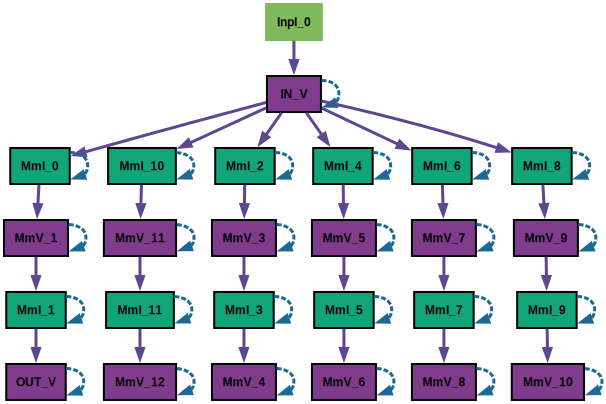

In [5]:
from ark.specification.specification import CDGSpec
from examples.tln.tln_example import make_full_graph


def make_hub_and_spoke(num_spokes: int, spoke_length: int, mismatch=True) -> tuple[CDG, CDGSpec]:
    graph, spec = make_full_graph(mismatch=mismatch, branch_args_override={
        'line_len': spoke_length,
        'branch_stride': spoke_length,
        'branches_per_node': num_spokes,
        'branch_len': spoke_length - 1,
        'branch_offset': 0,
    })
    return graph, spec

# graph, spec = make_hub_and_spoke(num_spokes=2, spoke_length=3, mismatch=True)

branch_args = {
    "line_len": 2,
    "branch_stride": 2,
    "branches_per_node": 5,
    "branch_len": 1,
    "branch_offset": 0,
}
graph, spec = make_full_graph(mismatch=True,
                              branch_args_override=branch_args)


from ark.visualize.graphviz_gen import cdg_to_graphviz_display
cdg_to_graphviz_display(cdg_lang=spec, cdg=graph)

### Add nonlinearities between tline branches

In [6]:
# Modify graph to add nonlinearities between some of the branches
def find_node(name: str):
    return next(node for node in graph.nodes if node.name == name)
print(graph.edges[25].cdg_type)
find_node('MmV_1')

<class 'ark.specification.cdg_types.MmE'>


In [7]:
MmE = spec.edge_types()[0]

In [8]:
add_edges_between = [('MmV_1', 'MmI_11'), ('MmV_11', 'MmI_2'), ('MmV_3', 'MmI_4'), ('MmV_5', 'MmI_7')]

for v_node, i_node in add_edges_between:
    graph.connect(edge=MmE(ws=1.0, wt=1.0), src=find_node(v_node), dst=find_node(i_node))

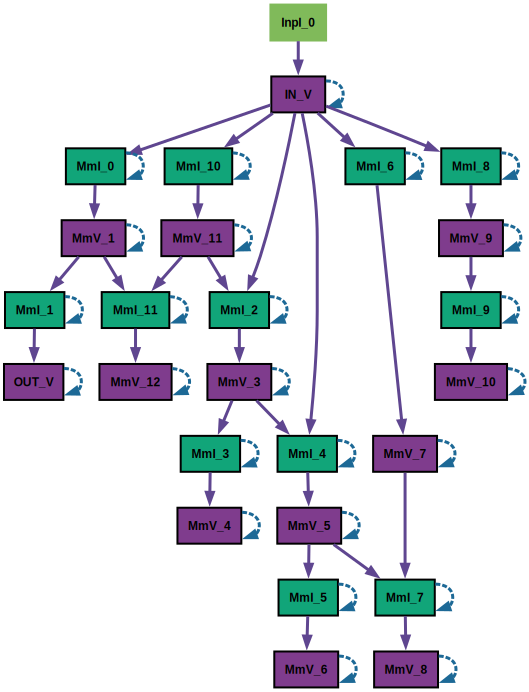

In [9]:
cdg_to_graphviz_display(cdg_lang=spec, cdg=graph)

Now we have a graph with representing the TLN with certain arguments, and can compile it to SymPy expressions.

In [10]:
from ark.simulate.dynamical_system import DynamicalSystem
ds = DynamicalSystem.from_ark(cdg=graph, spec=spec)
ds

Compiling order 0 nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Compiling order 1 nodes:   0%|          | 0/25 [00:00<?, ?it/s]

/lfs/ampere9/0/roed/projects/Ark/ark/simulate/dynamical_system.py:224: UserWarning: Replacing InpI_0_fn with default expression
  warn("Replacing InpI_0_fn with default expression")


In [11]:
eq = ds.diffeqs[0]
# sp.simplify(eq.rhs.args[0].subs({sp.symbols('t'): 10000 * sp.symbols('t')}))
# eq.rhs.free_symbols
t = ds.time_symbol()
k = sp.symbols('k', positive=True)
# eq_k = eq.rhs.subs({t: k * t})


def scale_variable_extraction(expr: sp.Expr, symbol: sp.Symbol, scale_factor: float) -> sp.Expr:
    match expr:
        case sp.Symbol() if expr == symbol:
            return expr, True
        case sp.core.operations.AssocOp(args=args):
            new_args = []
            all_bring_out = True
            for arg in args:
                new_arg, bring_out = scale_variable_extraction()
                if not bring_out:
                    all_bring_out = False
            new_args = tuple(new_args)
            return expr.__class__(args=new_args), 
    if symbol in expr.free_symbols:
        pass
        
# eq.rhs.args[0].subs({sp.symbols('t'): 100 * sp.symbols('t')}).simplify()
# sp.simplify(eq)

# display(x := eq.rhs.args[0].args[2])
# # scale_variable_extraction(x, sp.symbols('t'), 10.0)
# a, b = sp.symbols('a b', positive=True)
# e = a * t + b * t
# sp.collect(eq_k, k)
# display(sp.nsimplify(eq_k.args[0].args[2].args[1].args[0].args[1].args[1]))
# display(eq_k)
# # polys = [[([sp.Poly(ex, t, domain='QQ') for ex in eq_k.args[0].args[2].args[1].args[0].args[1].args], '<')]]
# # print(polys)
# display(eqs := [eq_k.args[0].args[2].args[1].args[i][1] for i in range(len(eq_k.args[0].args[2].args[1].args))])
# 
# display(sp.solve(eqs[3], t))
# eqs_fixed = [sp.solve(e, t) for e in eqs]
# display(eqs_fixed)
# fix_list = [(b, a.subs({k: 1e-9})) for b, a in zip(eqs, eqs_fixed) if not isinstance(a, list)]
# print(fix_list)
# eq_k.subs(fix_list).subs({k: 1e-9})
# 
# def fix_piecewise_ts(*args):
#     fixed_args = [(a[0], sp.solve(a[1], t)) for a in args]
#     new_args = [
#         (a[0].simplify(), a[1] if not isinstance(a[1], list) else True)
#         for a in fixed_args
#     ]
#     print(new_args)
#     return sp.Piecewise(*new_args)
#     
# eq_k.replace(sp.Piecewise, fix_piecewise_ts).subs(k, 1e-9)

In [12]:
ds.symbol_types

{t: Time(time_scale=1e-08),
 IN_V: Transient(name='IN_V', unit=<Unit('volt')>, noise=NoiseDescription()),
 MmI_0: Transient(name='MmI_0', unit=<Unit('ampere')>, noise=NoiseDescription()),
 MmI_1: Transient(name='MmI_1', unit=<Unit('ampere')>, noise=NoiseDescription()),
 MmI_2: Transient(name='MmI_2', unit=<Unit('ampere')>, noise=NoiseDescription()),
 MmI_3: Transient(name='MmI_3', unit=<Unit('ampere')>, noise=NoiseDescription()),
 MmI_4: Transient(name='MmI_4', unit=<Unit('ampere')>, noise=NoiseDescription()),
 MmI_5: Transient(name='MmI_5', unit=<Unit('ampere')>, noise=NoiseDescription()),
 MmI_6: Transient(name='MmI_6', unit=<Unit('ampere')>, noise=NoiseDescription()),
 MmI_7: Transient(name='MmI_7', unit=<Unit('ampere')>, noise=NoiseDescription()),
 MmI_8: Transient(name='MmI_8', unit=<Unit('ampere')>, noise=NoiseDescription()),
 MmI_9: Transient(name='MmI_9', unit=<Unit('ampere')>, noise=NoiseDescription()),
 MmI_10: Transient(name='MmI_10', unit=<Unit('ampere')>, noise=NoiseDescri

### Add non-linearities to each equation

In [13]:
# Find the added branches and wrap the equations in a tanh
non_linear_scale = 5e-8
non_linearity = lambda x: x

def pre_transform(expr: sp.Expr):
    match expr:
        case sp.Mul(args=(*_, sp.Pow(args=(_, -1)))):
            print(f'Found mul! {expr}')
            return non_linearity(expr)
        case sp.Symbol() | sp.Number() | sp.Integer() | sp.Tuple():
            return expr
    new_args = [
        pre_transform(arg)
        for arg in expr.args
    ]
    new_expr = expr.func(*new_args)
    return new_expr


In [14]:
# Wrap all multiply and divides in a non-linear function
non_linear_scale = 2e-8
scaled_tanh = lambda x: sp.tanh(non_linear_scale * x) / non_linear_scale
def chua_nonlinearity(x):
    return sp.Piecewise(
        (x, sp.Abs(x) < 0.1),
        (x * 0.5 + 0.5, True)
    )
nonlinearity = scaled_tanh
def pre_transform_with(expr: sp.Expr, with_variable_containing: str):
    match expr:
        case sp.Mul(args=(*_, sp.Pow(args=(_, -1)))):
            if with_variable_containing in map(str, expr.free_symbols):
                print(f'Found mul with {with_variable_containing} in {expr}')
                return nonlinearity(expr)
            return expr
        case sp.Symbol() | sp.Number() | sp.Integer() | sp.Tuple():
            return expr
    new_args = [
        pre_transform_with(arg, with_variable_containing=with_variable_containing)
        for arg in expr.args
    ]
    new_expr = expr.func(*new_args)
    return new_expr


def add_nonlinearity_to_eq(eq: sp.Eq):
    lhs_symbol = list(eq.lhs.free_symbols)[0]
    for first, second in add_edges_between:
        if first == lhs_symbol.name:
            print(f'Found first! {eq}')
            return pre_transform_with(eq, with_variable_containing=second)
        elif second == lhs_symbol.name:
            print(f'Found second! {eq}')
            return pre_transform_with(eq, with_variable_containing=first)
    return eq
# for eq in sympy_eqs_expanded:
#     add_nonlinearity_to_eq(eq)
# pre_transform_with(sympy_eqs_expanded[1])
# sympy_eqs_with_nonlinearity = [add_nonlinearity_to_eq(eq) for eq in sympy_eqs_expanded]
# for eq in sympy_eqs_with_nonlinearity:
#    display(eq)

# Hmm, that works, but maybe it's better to wrap the whole expression in a tanh instead

In [15]:
# def rhs_non_linearity(eq: sp.Eq):
#     assert isinstance(eq, sp.Eq)
#     return sp.Eq(eq.lhs, non_linearity(eq.rhs))
# 
# sympy_eqs_complete = [rhs_non_linearity(eq) if i != 0 else eq for i, eq in enumerate(sympy_eqs_expanded)]
# sympy_eqs_complete = sympy_eqs_with_nonlinearity
# sympy_eqs_complete = sympy_eqs_expanded
# sympy_eqs_complete

In [16]:
# Now we gather the parameters necessary from the respective nodes in the graph
all_param_vars = ds.parameter_symbols().keys()
def get_param_from_dict(param_name: str) -> float:
    element_name = '_'.join(param_name.split('_')[:-1])
    param_name = param_name.split('_')[-1]
    return graph_param_dict[element_name][param_name]

# Collect all node parameters into a dictionary with dictionary values
node_param_dict = {node.name: node.attrs for node in graph.nodes}
edge_param_dict = {edge.name: edge.attrs for edge in graph.edges}
graph_param_dict = node_param_dict | edge_param_dict

# Gather all necessary parameters in a flat dictionary
param_dict = {k: get_param_from_dict(k.name) for k in all_param_vars}
param_dict[sp.symbols('OUT_V_g', positive=True)] = 0.0
param_dict

{IN_V_c: 1e-09,
 IN_V_g: 0.0,
 InpI_0_g: 1.0,
 MmE_0_ws: 1.0,
 MmE_0_wt: 1.0,
 MmE_1_ws: 1.0,
 MmE_1_wt: 1.0,
 MmE_2_ws: 1.0,
 MmE_2_wt: 1.0,
 MmE_3_ws: 1.0,
 MmE_3_wt: 1.0,
 MmE_4_ws: 1.0,
 MmE_4_wt: 1.0,
 MmE_5_ws: 1.0,
 MmE_5_wt: 1.0,
 MmE_6_ws: 1.0,
 MmE_6_wt: 1.0,
 MmE_7_ws: 1.0,
 MmE_7_wt: 1.0,
 MmE_8_ws: 1.0,
 MmE_8_wt: 1.0,
 MmE_9_ws: 1.0,
 MmE_9_wt: 1.0,
 MmE_10_ws: 1.0,
 MmE_10_wt: 1.0,
 MmE_11_ws: 1.0,
 MmE_11_wt: 1.0,
 MmE_12_ws: 1.0,
 MmE_12_wt: 1.0,
 MmE_13_ws: 1.0,
 MmE_13_wt: 1.0,
 MmE_14_ws: 1.0,
 MmE_14_wt: 1.0,
 MmE_15_ws: 1.0,
 MmE_15_wt: 1.0,
 MmE_16_ws: 1.0,
 MmE_16_wt: 1.0,
 MmE_17_ws: 1.0,
 MmE_17_wt: 1.0,
 MmE_18_ws: 1.0,
 MmE_18_wt: 1.0,
 MmE_20_ws: 1.0,
 MmE_20_wt: 1.0,
 MmE_22_ws: 1.0,
 MmE_22_wt: 1.0,
 MmE_24_ws: 1.0,
 MmE_24_wt: 1.0,
 MmE_26_ws: 1.0,
 MmE_26_wt: 1.0,
 MmE_28_ws: 1.0,
 MmE_28_wt: 1.0,
 MmE_29_wt: 1.0,
 MmE_30_ws: 1.0,
 MmE_30_wt: 1.0,
 MmE_31_ws: 1.0,
 MmE_31_wt: 1.0,
 MmE_32_ws: 1.0,
 MmE_32_wt: 1.0,
 MmE_33_ws: 1.0,
 MmE_33_wt: 1.0,
 MmI_

In [17]:
# Gather initial values for the LHS variables
# TODO(marcelroed): Currently all at zero -- should this change?
print(ds.symbol_types)
lhs_vars = ds.transient_symbols()
lhs_init_dict = {k: 0.0 for k in lhs_vars.keys()}
lhs_init_dict

{t: Time(time_scale=1e-08), IN_V: Transient(name='IN_V', unit=<Unit('volt')>, noise=NoiseDescription()), MmI_0: Transient(name='MmI_0', unit=<Unit('ampere')>, noise=NoiseDescription()), MmI_1: Transient(name='MmI_1', unit=<Unit('ampere')>, noise=NoiseDescription()), MmI_2: Transient(name='MmI_2', unit=<Unit('ampere')>, noise=NoiseDescription()), MmI_3: Transient(name='MmI_3', unit=<Unit('ampere')>, noise=NoiseDescription()), MmI_4: Transient(name='MmI_4', unit=<Unit('ampere')>, noise=NoiseDescription()), MmI_5: Transient(name='MmI_5', unit=<Unit('ampere')>, noise=NoiseDescription()), MmI_6: Transient(name='MmI_6', unit=<Unit('ampere')>, noise=NoiseDescription()), MmI_7: Transient(name='MmI_7', unit=<Unit('ampere')>, noise=NoiseDescription()), MmI_8: Transient(name='MmI_8', unit=<Unit('ampere')>, noise=NoiseDescription()), MmI_9: Transient(name='MmI_9', unit=<Unit('ampere')>, noise=NoiseDescription()), MmI_10: Transient(name='MmI_10', unit=<Unit('ampere')>, noise=NoiseDescription()), Mm

{IN_V: 0.0,
 MmI_0: 0.0,
 MmI_1: 0.0,
 MmI_2: 0.0,
 MmI_3: 0.0,
 MmI_4: 0.0,
 MmI_5: 0.0,
 MmI_6: 0.0,
 MmI_7: 0.0,
 MmI_8: 0.0,
 MmI_9: 0.0,
 MmI_10: 0.0,
 MmI_11: 0.0,
 MmV_1: 0.0,
 MmV_3: 0.0,
 MmV_4: 0.0,
 MmV_5: 0.0,
 MmV_6: 0.0,
 MmV_7: 0.0,
 MmV_8: 0.0,
 MmV_9: 0.0,
 MmV_10: 0.0,
 MmV_11: 0.0,
 MmV_12: 0.0,
 OUT_V: 0.0}

### Reminder of relevant variables

In [18]:
display(ds)
display(param_dict)  # Mapping of all parameters to be simulated -- are what we want sensitivities for

{IN_V_c: 1e-09,
 IN_V_g: 0.0,
 InpI_0_g: 1.0,
 MmE_0_ws: 1.0,
 MmE_0_wt: 1.0,
 MmE_1_ws: 1.0,
 MmE_1_wt: 1.0,
 MmE_2_ws: 1.0,
 MmE_2_wt: 1.0,
 MmE_3_ws: 1.0,
 MmE_3_wt: 1.0,
 MmE_4_ws: 1.0,
 MmE_4_wt: 1.0,
 MmE_5_ws: 1.0,
 MmE_5_wt: 1.0,
 MmE_6_ws: 1.0,
 MmE_6_wt: 1.0,
 MmE_7_ws: 1.0,
 MmE_7_wt: 1.0,
 MmE_8_ws: 1.0,
 MmE_8_wt: 1.0,
 MmE_9_ws: 1.0,
 MmE_9_wt: 1.0,
 MmE_10_ws: 1.0,
 MmE_10_wt: 1.0,
 MmE_11_ws: 1.0,
 MmE_11_wt: 1.0,
 MmE_12_ws: 1.0,
 MmE_12_wt: 1.0,
 MmE_13_ws: 1.0,
 MmE_13_wt: 1.0,
 MmE_14_ws: 1.0,
 MmE_14_wt: 1.0,
 MmE_15_ws: 1.0,
 MmE_15_wt: 1.0,
 MmE_16_ws: 1.0,
 MmE_16_wt: 1.0,
 MmE_17_ws: 1.0,
 MmE_17_wt: 1.0,
 MmE_18_ws: 1.0,
 MmE_18_wt: 1.0,
 MmE_20_ws: 1.0,
 MmE_20_wt: 1.0,
 MmE_22_ws: 1.0,
 MmE_22_wt: 1.0,
 MmE_24_ws: 1.0,
 MmE_24_wt: 1.0,
 MmE_26_ws: 1.0,
 MmE_26_wt: 1.0,
 MmE_28_ws: 1.0,
 MmE_28_wt: 1.0,
 MmE_29_wt: 1.0,
 MmE_30_ws: 1.0,
 MmE_30_wt: 1.0,
 MmE_31_ws: 1.0,
 MmE_31_wt: 1.0,
 MmE_32_ws: 1.0,
 MmE_32_wt: 1.0,
 MmE_33_ws: 1.0,
 MmE_33_wt: 1.0,
 MmI_

In [19]:
gradient_mask = jnp.array([False if s.name.endswith('c') or s.name.endswith('l') else True for s in ds.parameter_symbols().keys()], dtype=bool)
gradient_mask

Array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True, False,
        True, False,  True, False,  True, False,  True, False,  True,
       False,  True, False,  True, False,  True, False,  True, False,
        True, False,  True, False,  True, False,  True, False,  True,
       False,  True, False,  True, False,  True, False,  True, False,
        True, False,  True, False,  True, False,  True, False,  True],      dtype=bool)

## Defining the DiffEQ solve function


In [20]:
# config.update("jax_debug_nans", False)
# print({k: v for k, v in param_dict.items()})
# print({symbol: parameter_values[i] for i, symbol in enumerate(param_dict.keys())})
# print(list(zip([next(iter(eq.lhs.free_symbols))for eq in ds.diffeqs], ds.transient_symbols())))
# print(initial_values, parameter_values)
# jax.jit(ds.f)(1.0e-8, initial_values, parameter_values)
print(ds.parameter_symbols().keys())
print(param_dict.keys())
print(set(ds.parameter_symbols()).difference(param_dict.keys()))
parameter_values = ds.encode_parameters(param_dict)

dict_keys([IN_V_c, IN_V_g, InpI_0_g, MmE_0_ws, MmE_0_wt, MmE_1_ws, MmE_1_wt, MmE_2_ws, MmE_2_wt, MmE_3_ws, MmE_3_wt, MmE_4_ws, MmE_4_wt, MmE_5_ws, MmE_5_wt, MmE_6_ws, MmE_6_wt, MmE_7_ws, MmE_7_wt, MmE_8_ws, MmE_8_wt, MmE_9_ws, MmE_9_wt, MmE_10_ws, MmE_10_wt, MmE_11_ws, MmE_11_wt, MmE_12_ws, MmE_12_wt, MmE_13_ws, MmE_13_wt, MmE_14_ws, MmE_14_wt, MmE_15_ws, MmE_15_wt, MmE_16_ws, MmE_16_wt, MmE_17_ws, MmE_17_wt, MmE_18_ws, MmE_18_wt, MmE_20_ws, MmE_20_wt, MmE_22_ws, MmE_22_wt, MmE_24_ws, MmE_24_wt, MmE_26_ws, MmE_26_wt, MmE_28_ws, MmE_28_wt, MmE_29_wt, MmE_30_ws, MmE_30_wt, MmE_31_ws, MmE_31_wt, MmE_32_ws, MmE_32_wt, MmE_33_ws, MmE_33_wt, MmI_0_l, MmI_0_r, MmI_1_l, MmI_1_r, MmI_2_l, MmI_2_r, MmI_3_l, MmI_3_r, MmI_4_l, MmI_4_r, MmI_5_l, MmI_5_r, MmI_6_l, MmI_6_r, MmI_7_l, MmI_7_r, MmI_8_l, MmI_8_r, MmI_9_l, MmI_9_r, MmI_10_l, MmI_10_r, MmI_11_l, MmI_11_r, MmV_1_c, MmV_1_g, MmV_3_c, MmV_3_g, MmV_4_c, MmV_4_g, MmV_5_c, MmV_5_g, MmV_6_c, MmV_6_g, MmV_7_c, MmV_7_g, MmV_8_c, MmV_8_g, MmV_9_c, M

In [21]:
from contextlib import contextmanager
from time import perf_counter
from ark.simulate.circuit_system import CircuitSystem

@contextmanager
def time_block(name: str):
    try:
        start_time = perf_counter()
        print(f"Starting {name}")
        yield
    finally:
        print(f'{name} took {perf_counter() - start_time} seconds')

# with time_block("compile"):
#     solve_system.lower(initial_values=keys_to_str(lhs_init_dict), parameter_values=keys_to_str(param_dict), saveat=dr.SaveAt(steps=True)).compile()
cs = CircuitSystem(dynamical_system=ds, parameter_state=parameter_values)
random_keys = jrandom.bits(jrandom.PRNGKey(0), (8192, 2), dtype=jnp.uint32)
if jax.devices()[0].platform == 'cpu':
    cpu_sharding = jax.sharding.PositionalSharding(jax.devices()).reshape(-1, 1)
    cpu_sharding = jax.sharding.PositionalSharding(jax.devices()).reshape(-1, 1)
    random_keys = jax.device_put(random_keys, cpu_sharding)
    jax.debug.visualize_array_sharding(random_keys)

solve_for_all_keys = eqx.filter_jit(eqx.filter_vmap(CircuitSystem.sample_solve, in_axes=(None, 0, None)))

In [22]:
from functools import wraps


def timed_execution(f, name=None, jit_only=False):
    if name is None:
        name = f.__name__
        
    timer = None
    def start_timer():
        nonlocal timer
        print(f'Starting process {name}')
        timer = perf_counter()
        
    def end_timer():
        nonlocal timer
        if timer is None:
            print('Timer initialization failed...')
        total_time = perf_counter() - timer
        print(f'Process {name} took {total_time}')
        timer = None
    
    def to_jit(*args, **kwargs):
        if jit_only:
            jax.debug.callback(start_timer)
        result = f(*args, **kwargs)
        return result
        
    jitted = eqx.filter_jit(to_jit)
    
    @wraps(f)
    def inner(*args, **kwargs):
        if not jit_only:
            start_timer()
        result = jax.block_until_ready(jitted(*args, **kwargs))
        end_timer()
        return result
    return inner
    
with time_block('solve'):
# with jax.profiler.trace("/tmp/tensorboard"):
    all_results = timed_execution(solve_for_all_keys, jit_only=False)(cs, random_keys, dr.SaveAt(steps=True))
    # solution = solve_system_with_sensitivity(dynamical_system=ds, initial_values=initial_values, parameter_values=parameter_values, saveat=dr.SaveAt(steps=True))
    jax.block_until_ready(all_results)
    # print(all_results)
    # print(all_results.stats)

Starting solve
Starting process sample_solve


Starting system solve...
Process sample_solve took 11.659689585969318
solve took 11.660804867977276 seconds


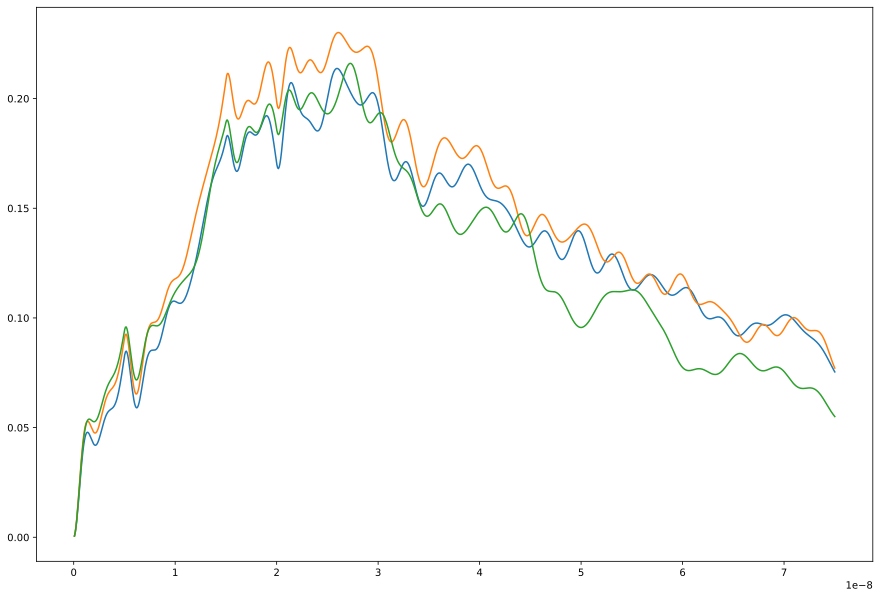

In [23]:
num_steps = all_results.stats['num_steps'][0]
# print(all_results.ts[0, :])
plt.plot(all_results.ts[0, :], all_results.ys[:3, :, 0].T)
plt.show()
# all_results.ys[0, :, 0]

[1000 1000 1000 ... 1000 1000 1000]


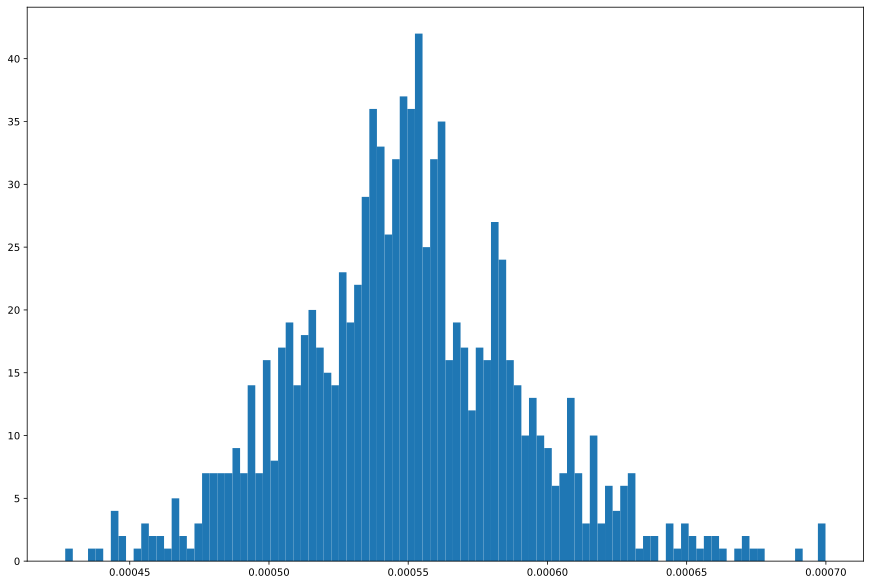

In [24]:
print(all_results.stats['num_steps'])
num_steps = all_results.stats['num_steps'][0]
plt.hist(all_results.ys[:num_steps, 0, 0], bins=100)
plt.show()

In [25]:
def parameter_sensitivity(cs: CircuitSystem, key: jax.Array):
    def get_y(cs: CircuitSystem):
        full_solution = cs.sample_solve(key)
        return full_solution.ys[-1, 0]
    return eqx.filter_grad(get_y)(cs).parameter_state / cs.parameter_state  # Relative sensitivities

def infmse(x):
    present_mask = ~jnp.isinf(x)
    n_present = jnp.sum(present_mask)
    return jnp.sum(jnp.where(present_mask, x ** 2, 0)) / n_present

def combined_loss(cs: CircuitSystem, key: jax.Array):
    def get_y_and_aug(cs: CircuitSystem):
        full_solution = cs.sample_solve_with_sensitivity(key)
        return full_solution.ys[-1, 0], jnp.sum(jnp.square(full_solution.ys[-1, full_solution.ys.shape[1] // 2:]))
    y_grad_params, sensitivity_loss = eqx.filter_grad(get_y_and_aug, has_aux=True)(cs)
    chaos_loss = infmse(y_grad_params.parameter_state / (cs.parameter_state * 1e9))
    return chaos_loss + sensitivity_loss, {'chaos_loss': chaos_loss, 'sensitivity_loss': sensitivity_loss}

# print('starting')
# display(eqx.filter_grad(combined_loss, has_aux=True)(cs, jrandom.PRNGKey(0)))

# print(len(cs.dynamical_system.parameter_symbols()))
# with time_block('compute loss'):
#     display(jax.block_until_ready(combined_loss(cs, jrandom.PRNGKey(0))))

# display(cs.parameter_state)
# parameter_sensitivity(cs, key=jrandom.PRNGKey(0))
def compute_total_sensitivity(cs, key):
    return jnp.sum(jnp.square(parameter_sensitivity(cs, key)))

# Higher order grads which are not supported right now
# grad_chaos_loss = eqx.filter_grad(compute_total_sensitivity)
# grad_chaos_loss(cs, jrandom.PRNGKey(0))

In [26]:
from ark.simulate.dynamical_system import AugmentedState
# First order gradients of the system ONLY

def chaos_loss(y_samples: jax.Array):
    sorted_ys = jnp.sort(y_samples, axis=0)
    rolling_diffs = sorted_ys[1:] - sorted_ys[:-1]
    return jnp.sum(1 / jnp.maximum(rolling_diffs, 1e-8))

# @eqx.filter_jit
def sample_combined_loss(cs: CircuitSystem, keys: jax.Array):
    def get_y_and_aug(cs: CircuitSystem, key: jax.Array):
        full_solution = cs.sample_solve_with_sensitivity(key)
        output_state: AugmentedState = full_solution.ys
        final_y_val = output_state.y[-1, 0]
        y_error = output_state.y_error  # Scalar
        theta_error = output_state.theta_error[0, :]  # (y_dim, param_dim)
        return final_y_val, jnp.linalg.norm(y_error), jnp.linalg.norm(theta_error)
    y_values, y_errors, theta_errors = eqx.filter_vmap(get_y_and_aug, in_axes=(None, 0))(cs, keys)
    noise_loss_value = jnp.log(jnp.mean(y_errors))
    chaos_loss_value = -jnp.log(jnp.mean(theta_errors) / 1e7)
    total_loss = chaos_loss_value + noise_loss_value
    return total_loss, {'chaos_loss': chaos_loss_value, 'noise_loss': noise_loss_value}
# print(f'Running for {random_keys.shape[0]} keys')
# result = eqx.filter_jit(sample_combined_loss)(cs, random_keys)
# display(result)
# jax.debug.visualize_array_sharding(result[0])

In [27]:
loss_value_and_grad = eqx.filter_grad(sample_combined_loss, has_aux=True)

In [28]:
from optax import adam, OptState, apply_updates
from collections import defaultdict
optimizer = adam(learning_rate=10e-4)

@eqx.filter_jit
def update_step(state, opt_state, random_keys):
    cs_grad, metrics = loss_value_and_grad(state, random_keys)
    updates, opt_state = optimizer.update(cs_grad, opt_state)
    updates = eqx.tree_at(lambda x: x.parameter_state, updates, replace_fn=lambda s: jnp.where(gradient_mask, s, 0))
    state = eqx.apply_updates(state, updates)
    state = eqx.filter_jit(CircuitSystem.clamp_parameters)(state)
    return state, opt_state, metrics

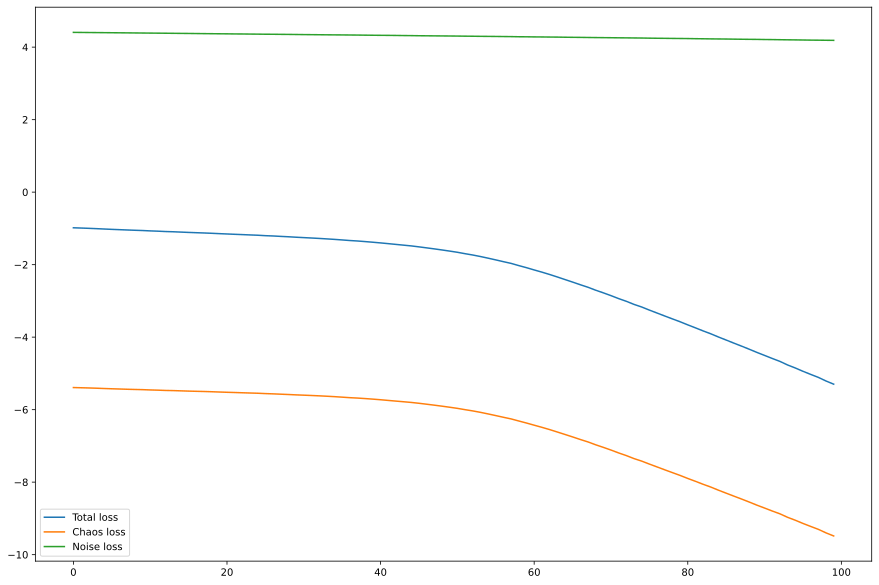

All losses = defaultdict(<class 'list'>, {'chaos_loss': [-5.390605846522257, -5.396042486401342, -5.401726166186293, -5.408755110815597, -5.416890708696892, -5.424315652508931, -5.430785950199017, -5.437641864085125, -5.44329998681396, -5.448252757765639, -5.456495763222396, -5.4625611280083275, -5.470491644754114, -5.4745958890775155, -5.48159507583504, -5.48858301238378, -5.494119080849458, -5.499243987524819, -5.505851854050399, -5.513720882490745, -5.521067731638765, -5.527312491299492, -5.53446571633511, -5.541046708140415, -5.547383344239371, -5.557087949284811, -5.564578708436716, -5.573662783259595, -5.582462005054504, -5.592539005321574, -5.600758338041772, -5.609653224643131, -5.619143150779007, -5.6300080023723185, -5.64157084457682, -5.655656437354811, -5.669810724488283, -5.680687934464945, -5.694609074117803, -5.710025237608557, -5.726834260374917, -5.745782459142767, -5.764406891115606, -5.782324536064668, -5.801318103108946, -5.824340954485128, -5.850243413105057, -5.87

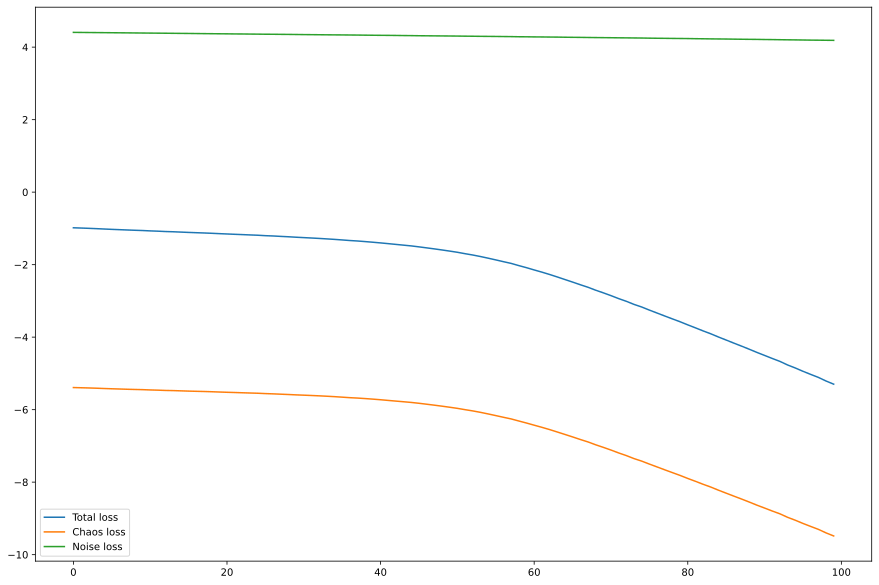

In [29]:
%matplotlib inline
# Optimize using this loss
# cs = CircuitSystem(dynamical_system=ds, parameter_state=parameter_values.astype(jnp.float16))
state = cs
opt_state = optimizer.init(state)
all_metrics = defaultdict(list)
from IPython import display as idisplay
from IPython.display import display


# validation_random_key = jrandom.bits(jrandom.PRNGKey(420), (1024, 2), dtype=jnp.uint32)

n_simultaneous = 50
n_iters = 100

print(state, opt_state, random_keys)

# with jax.profiler.trace("/tmp/tensorboard"):
for i in trange(n_iters):
    random_keys = jrandom.bits(jrandom.PRNGKey(0), (n_simultaneous, 2), dtype=jnp.uint32)
    # cs_grad, metrics = loss_value_and_grad(state, random_keys)
    # updates, opt_state = optimizer.update(cs_grad, opt_state)
    # state: CircuitSystem = eqx.apply_updates(state, updates)
    # state = state.clamp_parameters()

    state, opt_state, metrics = update_step(state, opt_state, random_keys)
    # print(state.parameter_state)
    total_loss = 0
    for k, v in metrics.items():
        v = float(v)
        all_metrics[k].append(v)
        total_loss += v
    all_metrics['total_loss'].append(total_loss)
    # print(state.parameter_state)
    print({k: all_metrics[k][-1] for k in all_metrics})
    # print(cs_grad)
    xs = np.arange(len(all_metrics['total_loss']))
    plt.close()
    if len(xs) > 1:
        plt.plot(xs, all_metrics['total_loss'], label='Total loss')
        plt.plot(xs, all_metrics['chaos_loss'], label='Chaos loss')
        plt.plot(xs, all_metrics['noise_loss'], label='Noise loss')
        plt.legend()
        idisplay.clear_output(wait=True)
        display(plt.gcf())
print(f'All losses = {all_metrics}')

In [ ]:
plt.plot(np.arange(n_iters), np.stack(list(all_metrics.values()), axis=-1))
plt.legend(list(all_metrics.keys()))
plt.show()

In [ ]:
state.parameter_state

In [ ]:
eqx.filter_jit(eqx.filter_grad(sample_combined_loss))(cs, random_keys).parameter_state

In [ ]:
end_step = solution.stats['num_steps']
plt.plot(solution.ts[:], solution.ys[:, :])
plt.legend([s.name for s in ds.transient_symbols()] + [s.name + ' error' for s in ds.transient_symbols()])
plt.xlabel('$t$ / s')
plt.gcf().set_size_inches(12, 8)
plt.savefig('full_solution.png', dpi=300)
# plt.ylim(-0.2, 1)
plt.show()
plt.plot(solution.ts, sp.lambdify(sp.symbols('t'), pulse_sympy(sp.symbols('t')))(solution.ts))
plt.legend(['IN_V'], loc='upper right')
plt.xlabel('$t$ / s')
plt.ylabel('IN_V / V')
plt.gcf().set_size_inches(12, 8)
plt.savefig('forcing_function.png', dpi=300)
plt.show()
print(solution.ys)
end_step

In [ ]:
solution.ys[end_step - 1]

In [ ]:
from functools import partial
# Show gradients of the solution graph with respect to a single parameter
n_ts = 1000
ts_space = jnp.linspace(0, 75e-9, 1000)
@eqx.filter_jit
def model_all_ts(parameters: dict) -> jax.Array:
    solution = solve_system(initial_values=keys_to_str(lhs_init_dict), parameter_values=parameters, saveat=dr.SaveAt(ts=ts_space))
    return solution.ys[:, -2:]

@eqx.filter_jit
def regularization_loss(parameters, ts, ys, ds: DynamicalSystem) -> jax.Array:
    """
    Aggregate gradients with respect to transient values y
    Automatically masks for nans and infs.
    """
    gradf_y = partial(jax.grad(ds.f, argnums=1), args=parameters)
    tys = jnp.stack((ts[:, None], ys), axis=0)
    def reduce_fun(current_loss: float, ty_value: jax.Array) -> float:
        new_loss = current_loss + jnp.linalg.norm(gradf_y(ty_value[0], ty_value[1:]), ord=2)
        return new_loss
    return jax.lax.reduce(tys, 0.0)

@eqx.filter_jit
def chaos_loss(ds: DynamicalSystem) -> float:
    pass

initial_parameters = {k: jnp.array(v) for k, v in keys_to_str(param_dict).items()}
model_grad_fn = jax.jit(jax.jacfwd(model_all_ts))
model_grad = model_grad_fn(initial_parameters)
model_vals = model_all_ts(initial_parameters)
model_grad

In [ ]:
from optax import adam, OptState, apply_updates
print(model_grad.keys())
print(model_vals.shape)
current_parameters = initial_parameters.copy()
start_value = current_parameters['MmE_26_ws']
print(start_value)
t_indices = [200, 400, 600]
goal_values = [0.6, 0.1, 0.2]

def loss(parameters):
    model_vals = model_all_ts(parameters)
    return sum((model_vals[t, -1] - goal_values[i])**2 for i, t in enumerate(t_indices))

loss_grad = jax.jit(jax.grad(loss))
optimizer = adam(learning_rate=2e-11)


@jax.jit
def step_parameters(current_parameters, optimizer_state):
    grads = loss_grad(current_parameters)
    updates, optimizer_state = optimizer.update(grads, optimizer_state)
    new_parameters = apply_updates(current_parameters, updates)
    new_parameters = {k: jnp.clip(v, 1e-10, 1e-8) if k.endswith('_l') or k.endswith('_c') else jnp.clip(v, 0.0, None) for k, v in new_parameters.items()}
    return new_parameters, optimizer_state


In [ ]:
optimizer_state = optimizer.init(current_parameters)
for step in trange(50):
    # model_vals = model_all_ts(current_parameters)
    # model_grad = model_grad_fn(current_parameters)

    model_vals = model_all_ts(current_parameters)
    plt.plot(ts_space, model_vals[:, -1])
    plt.scatter([ts_space[t] for t in t_indices], goal_values)
    plt.gcf().set_size_inches(8, 6)
    plt.xlabel('$t$ / s')
    plt.ylabel('OUT_V / V')
    plt.ylim(-0.1, 0.7)
    plt.savefig(f'step_{step}.png', dpi=300)
    plt.show()
    
    # plt.plot(ts_space, model_grad['MmE_26_ws'][:, -1])
    # Plot goal points
    # for i, (t, v, g) in enumerate(zip(ts_space, model_vals[:, -1], model_grad['MmE_26_ws'][:, -1])):
    #     if i % 10 == 0:
    #         plt.arrow(t, v, 0, g * 0.05, width=2e-10, head_length=0.02, lw=0)
    current_parameters, optimizer_state = step_parameters(current_parameters, optimizer_state)
    # print(current_parameters)


In [ ]:
def model_function(parameters: dict) -> jax.Array:
    """Produce the signal output of the model given a set of parameters."""
    solution = solve_system(initial_values=keys_to_str(lhs_init_dict), parameter_values=parameters, saveat=dr.SaveAt(ts=[3e-8,]))
    # Fetch the first timestep, and the first simulation variable (IN_V)
    return solution.ys[0][0]

initial_parameters = {k: jnp.array(v) for k, v in keys_to_str(param_dict).items()}
display(model_function(parameters=initial_parameters))
display(initial_parameters)

In [ ]:
model_grad = eqx.filter_jit(eqx.filter_grad(model_function))

@eqx.filter_jit
def loss_function(parameters: dict) -> jax.Array:
    """Gradients of the model function with respect to each parameter."""
    gradients = model_grad(parameters)
    return jnp.array(sum(gradients[key]**2 for key in gradients))

display(model_grad(initial_parameters))
loss_function(initial_parameters)

In [ ]:
from optax import adam, OptState, apply_updates

optimizer = adam(learning_rate=3e-4)
optimizer_state = optimizer.init(initial_parameters)

initial_parameters = {k: jnp.array(v) for k, v in keys_to_str(param_dict).items()}
@eqx.filter_jit
def step_single(parameters: dict, optimizer_state: OptState) -> tuple[jax.Array, dict, OptState]:
    loss_value, loss_gradients = eqx.filter_value_and_grad(loss_function)(parameters)
    updates, new_optimizer_state = optimizer.update(loss_gradients, optimizer_state)
    new_parameters = apply_updates(parameters, updates)
    return loss_value, new_parameters, new_optimizer_state

for i in range(100):
    loss_value, initial_parameters, optimizer_state = step_single(initial_parameters, optimizer_state)
    print(f'Loss at step {i}: {loss_value}')
    